In [7]:
import pandas as pd
from transformers import BertTokenizer


# Load datasets
prompts_test = pd.read_csv("../data/prompts_test.csv")
prompts_train = pd.read_csv("../data/prompts_train.csv")
summaries_test = pd.read_csv("../data/summaries_test.csv")
summaries_train = pd.read_csv("../data/summaries_train.csv")

# Drop student_id column from summaries_train and summaries_test
summaries_train = summaries_train.drop(columns=['student_id'])
summaries_test = summaries_test.drop(columns=['student_id'])
summaries_train = summaries_train[:500]

id_mapping = {id_val: idx for idx, id_val in enumerate(prompts_train['prompt_id'].unique())}

summaries_train['prompt_id'] = summaries_train['prompt_id'].replace(id_mapping)
summaries_test['prompt_id'] = summaries_test['prompt_id'].replace(id_mapping)

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the 'text' column
texts = summaries_train['text'].tolist()
tokens = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=128)

In [8]:
import torch
from transformers import BertModel, BertTokenizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm


def get_embeddings_in_batches(texts, model, tokenizer, batch_size=32):
    total = len(texts)
    all_embeddings = []
    
    for i in tqdm(range(0, total, batch_size), desc="Processing batches"):
        batch_texts = texts[i:i+batch_size]
        tokens = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=512)
        
        with torch.no_grad():
            batch_embeddings = model(tokens['input_ids'])[0][:,0,:].numpy()
        
        all_embeddings.append(batch_embeddings)
    
    return np.concatenate(all_embeddings, axis=0)


# 1. Get BERT Embeddings
model = BertModel.from_pretrained('bert-base-uncased')
embeddings = get_embeddings_in_batches(texts, model, tokenizer)

# 2. Dimensionality Reduction
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

# 3. Clustering
n_clusters = 4  # Given that there are 4 prompt IDs
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(embeddings_pca)
labels = kmeans.labels_


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Processing batches: 100%|██████████| 16/16 [06:28<00:00, 24.25s/it]
c:\Users\sisun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarnin

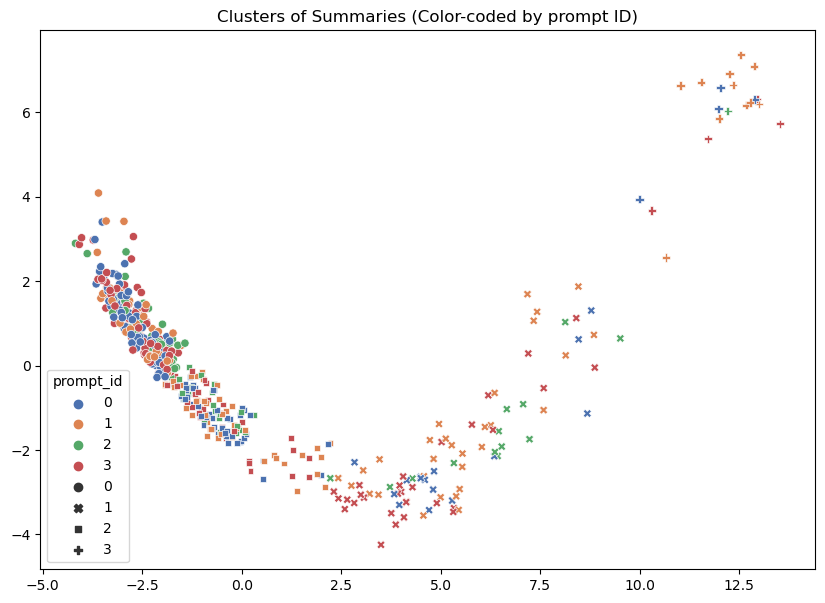

In [9]:
# Visualization
plt.figure(figsize=(10, 7))
sns.scatterplot(x=embeddings_pca[:, 0], y=embeddings_pca[:, 1], hue=summaries_train['prompt_id'], style=labels, palette="deep")
plt.title('Clusters of Summaries (Color-coded by prompt ID)')
plt.show()

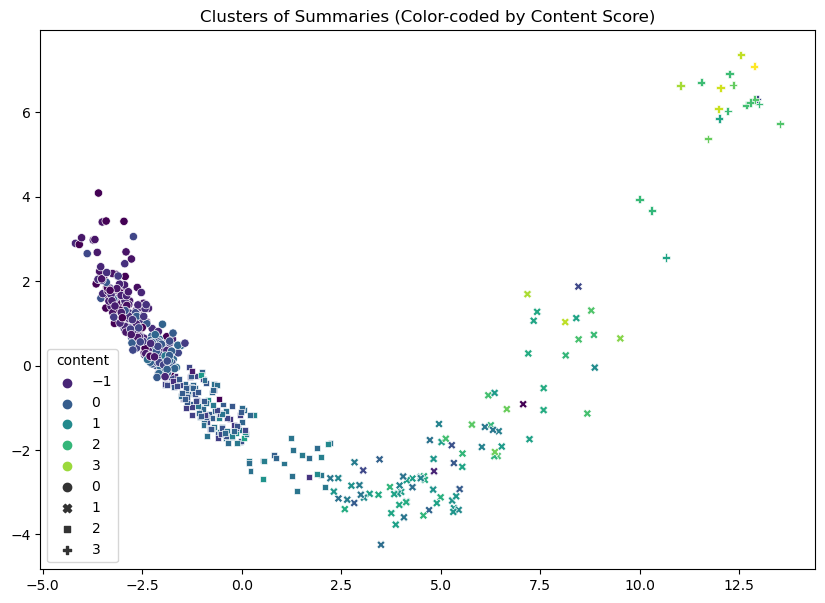

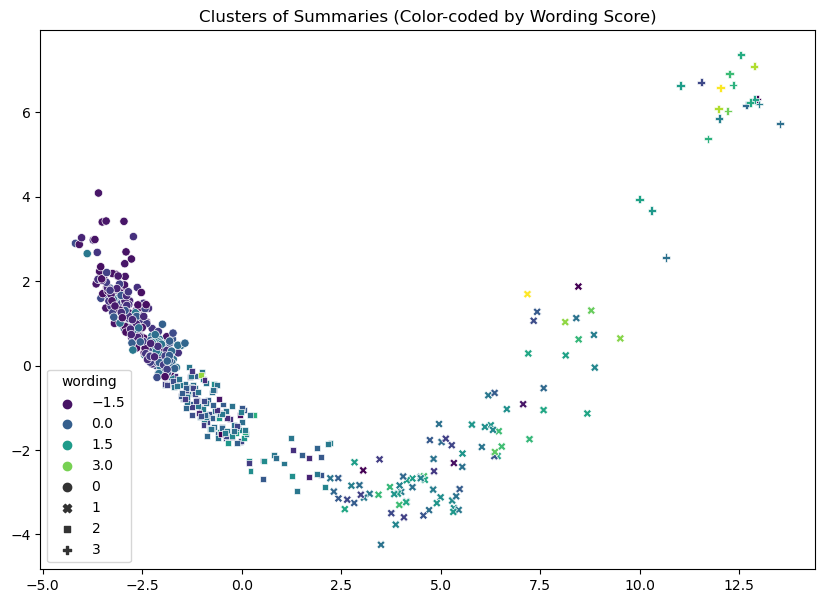

In [10]:
# Visualize with context scores
plt.figure(figsize=(10, 7))
sns.scatterplot(x=embeddings_pca[:, 0], y=embeddings_pca[:, 1], hue=summaries_train['content'], style=labels, palette="viridis")
plt.title('Clusters of Summaries (Color-coded by Content Score)')
plt.show()

# Visualize with wording scores
plt.figure(figsize=(10, 7))
sns.scatterplot(x=embeddings_pca[:, 0], y=embeddings_pca[:, 1], hue=summaries_train['wording'], style=labels, palette="viridis")
plt.title('Clusters of Summaries (Color-coded by Wording Score)')
plt.show()



In [11]:
summaries_train['cluster'] = labels
cluster_stats = summaries_train.groupby('cluster').agg({'content':'mean', 'wording':'mean'})
print(cluster_stats)


          content   wording
cluster                    
0       -0.732333 -0.635193
1        1.254618  0.834371
2        0.080307  0.099390
3        2.313364  1.547352


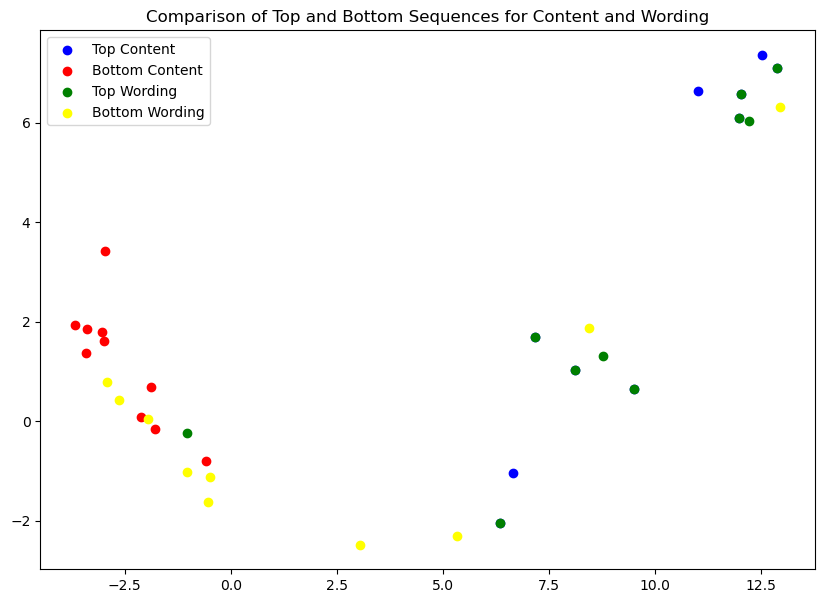

In [12]:
top_context_indices = summaries_train['content'].nlargest(10).index
bottom_context_indices = summaries_train['content'].nsmallest(10).index

top_wording_indices = summaries_train['wording'].nlargest(10).index
bottom_wording_indices = summaries_train['wording'].nsmallest(10).index

plt.figure(figsize=(10, 7))
plt.scatter(embeddings_pca[top_context_indices, 0], embeddings_pca[top_context_indices, 1], color='blue', label='Top Content')
plt.scatter(embeddings_pca[bottom_context_indices, 0], embeddings_pca[bottom_context_indices, 1], color='red', label='Bottom Content')
plt.scatter(embeddings_pca[top_wording_indices, 0], embeddings_pca[top_wording_indices, 1], color='green', label='Top Wording')
plt.scatter(embeddings_pca[bottom_wording_indices, 0], embeddings_pca[bottom_wording_indices, 1], color='yellow', label='Bottom Wording')
plt.legend()
plt.title('Comparison of Top and Bottom Sequences for Content and Wording')
plt.show()


## Content similarity

The score is not determined by the silirarity.